In [1]:
# Imports
import numpy as np
import scipy
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LightSource
import pickle
from itertools import combinations
from functools import reduce
from IPython.display import display, Math, Latex, HTML, clear_output

mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amsfonts,physics}'
%matplotlib inline

In [2]:
#Some code that implements progress bars for long computations
#https://www.mikulskibartosz.name/how-to-display-a-progress-bar-in-jupyter-notebook/
bar_length = 20
def update_progress(progress):
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [7]:
def aztec_vertices(n):
    lower_half = [(j, 2*i-1-j) for i in range(1, n+1) for j in range(2*i)]
    upper_half = [(2*n - y, 2*n - x) for x,y in lower_half]
    return lower_half + upper_half

def neighbors(p, n):
    x,y = p
    nebs = []
    if x > 0 and y > 0:
        nebs.append((x-1, y-1))
    if x > 0 and y < 2*n:
        nebs.append((x-1, y+1))
    if x < 2*n and y > 0:
        nebs.append((x+1, y-1))
    if x < 2*n and y < 2*n:
        nebs.append((x+1, y+1))
    return nebs

def aztec_edges(n):
    verts = aztec_vertices(n)
    edges = set()
    for v1 in verts:
        for v2 in neighbors(v1, n):
            if v1[0] <= v2[0]:
                if v1[1] < v2[1]:
                    edges.add((v1, v2))
                else:
                    edges.add((v1, v2))
            else:
                edges.add((v2, v1))
    return list(edges)

def edge_color(e):
    v1, v2 = e
    x1, y1 = v1
    x2, y2 = v2
    if y1 > y2:
        return 'y' if x1 % 2 == 0 else 'g'
    else:
        return 'r' if x1 % 2 == 0 else 'b'

def plot_matching(matching, ax):
    """
    Plot the given matching on the given axis.
    The matching should be an enumerable collection of edges of the form returned by aztec_edges.
    """
    for v1,v2 in matching:
        x1, y1 = v1
        x2, y2 = v2
        if y1 > y2: # NW - SE tile
            width = 2*np.sqrt(2)
            height = np.sqrt(2)
            color = 'y' if x1 % 2 == 0 else 'g'
        else: # NE - SW tile
            width = np.sqrt(2)
            height = 2*np.sqrt(2)
            color = 'r' if x1 %  2 == 0 else 'b'
        angle = -45
        anchor = (x1-1, y1)
        rect = mpl.patches.Rectangle(anchor,width,height,angle=angle,linewidth=1,facecolor=color)
        ax.add_patch(rect)
    ax.autoscale_view()
    ax.set_aspect('equal')
    ax.axis('off')
    return ax


def find_squares(free_verts, free_edges):
    squares = []
    for x,y in free_verts:
        e1 = ((x,y), (x+1, y+1))
        e2 = ((x,y), (x+1, y-1))
        e3 = ((x+1,y+1), (x+2, y))
        e4 = ((x+1, y-1), (x+2, y))
        if all([e in free_edges for e in [e1, e2, e3, e4]]):
            squares.append((x,y))
    return squares

def possible_overlap_squares(square):
    x,y = square
    return [(x+1, y+1), (x+1, y-1), (x-1, y+1), (x-1, y-1), (x+2, y), (x-2, y), (x, y+2), (x, y-2)]

def expand_matching(matching, n):
    new_matching = []

    # Move/delete edges
    for v1,v2 in matching:
        x1, y1 = v1
        x2, y2 = v2
        if y1 > y2:
            if x1 % 2 == 0:
                moved_edge = ((x1-1, y1-1), (x2-1, y2-1))
            else:
                moved_edge = ((x1+1, y1+1), (x2+1, y2+1))
        else:
            if x1 % 2 == 0:
                moved_edge = ((x1-1, y1+1), (x2-1, y2+1))
            else:
                moved_edge = ((x1+1, y1-1), (x2+1, y2-1))
        if not (moved_edge in matching):
            new_matching.append(moved_edge)

    # shift everything back to where it should be
    new_matching = [((v1[0]+1, v1[1]+1), (v2[0]+1, v2[1]+1)) for v1,v2 in new_matching]
    foo = list(new_matching)

    # Determine free vertices/edges in order to find squares
    full_edge_set = aztec_edges(n+1)
    full_vertex_set = aztec_vertices(n+1)
    free_vertex_set = [vert for vert in full_vertex_set if not any([vert in e for e in new_matching])]
    free_edge_set = [e for e in full_edge_set if e[0] in free_vertex_set and e[1] in free_vertex_set] 

    # find all available squares (identified by left corner)
    squares = sorted(find_squares(free_vertex_set, free_edge_set), key=lambda x: x[0])
    
    # Fill in the rest of the diamond, start w/ squares w/ lowest degree
    while len(free_edge_set) > 0:
        x,y = squares.pop()
        if np.random.rand() > 0.5:
            e1 = ((x, y), (x+1, y+1))
            e2 = ((x+1, y-1), (x+2, y))
        else:
            e1 = ((x,y), (x+1, y-1))
            e2 = ((x+1, y+1), (x+2, y))
        
        new_matching += [e1, e2]
        
        # update free vertex/edge sets
        free_edge_set = [e for e in free_edge_set if not ((e1[0] in e) or (e1[1] in e) or (e2[0] in e) or (e2[1] in e))]
        free_vertex_set = [v for v in free_vertex_set if not v in list(e1)+list(e2)]

        # update squares
        for sq in possible_overlap_squares((x,y)):
            if sq in squares:
                squares.remove(sq)

    return new_matching, foo

def iterative_expand_matching(matching, goal_N):
    N = int(max(np.array(matching).flatten()) / 2)
    for i in range(N, goal_N + 1):
        matching, _ = expand_matching(matching, i)
    return matching

In [ ]:
N = 2
matching = [((0, 1), (1, 0)), ((1, 2), (2, 1)), ((2, 3), (3, 2)), ((3, 4), (4, 3)), ((0, 3), (1, 4)), ((3, 0), (4, 1))]
while N < 15:
    fig, ax = plt.subplots()
    plot_matching(matching, ax)
    plt.plot(*zip(*aztec_vertices(N)), '.', color='black', markersize=5/np.sqrt(N))
    plt.title("$N = $" + str(N))
    plt.show()
    matching, _ = expand_matching(matching, N)
    N += 1

In [ ]:
matching = [((0, 1), (1, 0)), ((1, 2), (2, 1)), ((2, 3), (3, 2)), ((3, 4), (4, 3)), ((0, 3), (1, 4)), ((3, 0), (4, 1))]
new_matching = iterative_expand_matching(matching, 100)
fig, ax = plt.subplots(figsize=(15,15))
ax = plot_matching(new_matching, ax)
ax.set_title("$N = 100$ Random Aztec Diamond")

In [19]:
N_max = 500
matchings = [[((0, 1), (1, 0)), ((1, 2), (2, 1))] ]
expansions = []
for i in range(len(matchings), N_max+1):
    match, exp = expand_matching(matchings[-1], i)
    matchings.append(match)
    expansions.append(exp)
    update_progress(i / (N_max - 1))
    if i % 20 == 0:
        with open("data/match{}.pk".format(i), 'wb') as file:
            pickle.dump(matchings, file)


Progress: [#######-------------] 37.5%


KeyboardInterrupt: 

In [17]:
with open("match370.pk", 'wb') as file:
    pickle.dump(matchings, file)

Progress: [--------------------] 0.3%


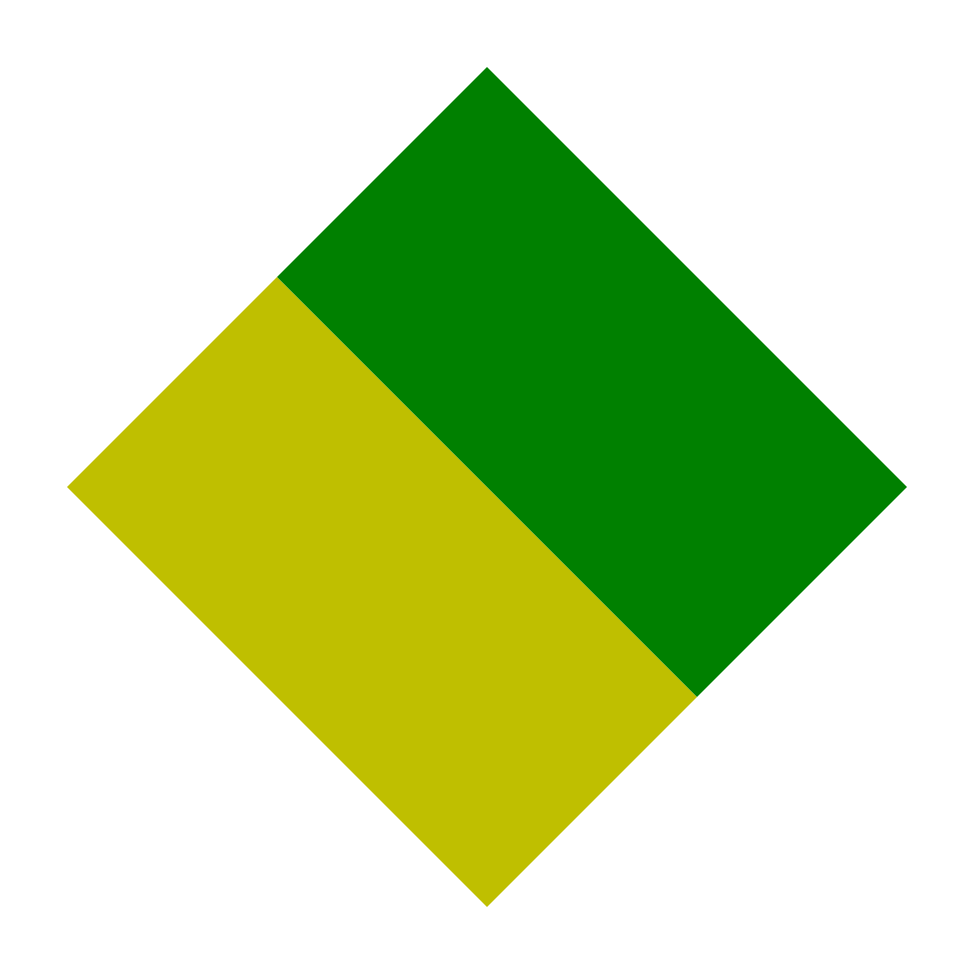

In [18]:
fig, ax = plt.subplots()

def update(frame):
    plt.cla()
    plot_matching(matchings[frame], ax)
    update_progress((frame + 1) / len(matchings))

video = animation.FuncAnimation(fig, update, len(matchings), interval=50)

#Save the animation
video.save("AD_animation_370.mp4")

In [ ]:
matching = [((0, 1), (1, 0)), ((1, 2), (2, 1)), ((2, 3), (3, 2)), ((3, 4), (4, 3)), ((0, 3), (1, 4)), ((3, 0), (4, 1))]
new_matching = iterative_expand_matching(matching, 100)
fig, ax = plt.subplots(figsize=(15,15))
ax = plot_matching(new_matching, ax)

In [5]:
class match_edge:
    def __init__(self, e: tuple[tuple[int,int], tuple[int, int]], color:str):
        self.age = 0
        self.e = e
        self.color = color

    def copy(self):
        m = match_edge(self.e, self.color)
        m.age = self.age
        return m

def expand_matching2(matching: list[match_edge], n):
    new_matching = []

    # Move/delete edges
    for m in matching:
        v1, v2 = m.e
        x1, y1 = v1
        x2, y2 = v2
        if y1 > y2:
            if x1 % 2 == 0:
                moved_edge = ((x1-1, y1-1), (x2-1, y2-1))
            else:
                moved_edge = ((x1+1, y1+1), (x2+1, y2+1))
        else:
            if x1 % 2 == 0:
                moved_edge = ((x1-1, y1+1), (x2-1, y2+1))
            else:
                moved_edge = ((x1+1, y1-1), (x2+1, y2-1))
        if not any([match.e == moved_edge for match in matching]):
            m2 = m.copy()
            m2.e = moved_edge
            m2.age += 1
            new_matching.append(m2)

    # shift everything back to where it should be
    for m in new_matching:
        v1,v2 = m.e
        m.e = ((v1[0]+1, v1[1]+1), (v2[0]+1, v2[1]+1))

    # Determine free vertices/edges in order to find squares
    full_edge_set = aztec_edges(n+1)
    full_vertex_set = aztec_vertices(n+1)
    free_vertex_set = [vert for vert in full_vertex_set if not any([vert in m.e for m in new_matching])]
    free_edge_set = [e for e in full_edge_set if e[0] in free_vertex_set and e[1] in free_vertex_set] 

    # find all available squares (identified by left corner)
    squares = sorted(find_squares(free_vertex_set, free_edge_set), key=lambda x: x[0])
    
    # Fill in the rest of the diamond, start w/ squares w/ lowest degree
    while len(free_edge_set) > 0:
        x,y = squares.pop()
        if np.random.rand() > 0.5:
            e1 = ((x, y), (x+1, y+1))
            e2 = ((x+1, y-1), (x+2, y))
        else:
            e1 = ((x,y), (x+1, y-1))
            e2 = ((x+1, y+1), (x+2, y))
        
        new_matching += [match_edge(e1, edge_color(e1)), match_edge(e2, edge_color(e2))]
        
        # update free vertex/edge sets
        free_edge_set = [e for e in free_edge_set if not ((e1[0] in e) or (e1[1] in e) or (e2[0] in e) or (e2[1] in e))]
        free_vertex_set = [v for v in free_vertex_set if not v in list(e1)+list(e2)]

        # update squares
        for sq in possible_overlap_squares((x,y)):
            if sq in squares:
                squares.remove(sq)

    return new_matching

In [62]:
edges = [((0, 1), (1, 0)), ((1, 2), (2, 1)), ((2, 3), (3, 2)), ((3, 4), (4, 3)), ((0, 3), (1, 4)), ((3, 0), (4, 1))]
matchings = [[match_edge(e, edge_color(e)) for e in edges]]
for i in range(2, 150):
    matchings.append(expand_matching2(matchings[-1], i))

In [ ]:
fig, ax = plt.subplots()

def plot_ages(frame):
    plt.cla()
    ages = [m.age for m in matchings[frame]]
    counts = [len([age for age in ages if age == i])/len(ages) for i in range(frame+1)]
    scaled_ages = [i / (frame + 1) for i in range(frame+1)]
    plt.bar(scaled_ages, counts, 1/len(counts))
    if frame > 0:
        plt.ylim(0, 0.35)
    plt.title("Population Age Distribution ($N = {}$)".format(frame+2))
    plt.xlabel("Age (scaled)")
    plt.ylabel("Population Proportion")

video = animation.FuncAnimation(fig, plot_ages, len(matchings))

#Save the animation
#video.save("ages7.mp4")

In [ ]:
stack = [[3, 2, 1],
         [1, 1, 0],
         [1, 0, 0]]
stack = np.array(stack)

def plot_plane_partition(part):
    N = len(part)
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    xx, yy = np.meshgrid(np.arange(N), np.arange(N))
    x, y = xx.ravel(), yy.ravel()

    top = np.array(part).flatten()
    bottom = np.zeros_like(top)
    width = depth = 1

    ls = LightSource(azdeg=90, altdeg=89)

    ax.bar3d(x, y, bottom, width, depth, top, shade=True, lightsource=ls)
    ax.view_init(40, 49)
    ax.axis('off')


plot_plane_partition(stack)
plt.show()

In [5]:
def valid_partition(part):
    for i in range(1,len(part)):
        for j in range(1,len(part)):
            if part[i-1, j] < part[i, j]:
                return False
            if part[i, j-1] < part[i, j]:
                return False
    return True

def comparable_partitions(partA, partB):
    return all([a <= b for a,b in zip(partA.flatten(), partB.flatten())])

def compare_partitions(partA, partB):
    if not comparable_partitions(partA, partB):
        raise Exception("incomparable partitions")
    return partA[0][0] <= partB[0][0]

def do_move(partition, pos, delta):
    N = len(partition)
    x = pos // N
    y = pos % N
    new_height = partition[x, y] + delta
    valid_height = 0 <= new_height and new_height <= N
    if x > 0:
        valid_height = valid_height and partition[x-1, y] >= new_height
    if x < N-1:
        valid_height = valid_height and new_height >= partition[x+1, y]
    if y > 0:
        valid_height = valid_height and partition[x, y-1] >= new_height
    if y < N-1:
        valid_height = valid_height and new_height >= partition[x, y+1]
    if valid_height:
        partition[x, y] += delta
    return partition, valid_height


min_partition = lambda n: np.zeros((n,n))
max_partition = lambda n: np.ones((n,n))*n

20 20 20 20 19 19 19 19 19 19 18 18 18 17 16 16 15 15 11 11
20 20 20 20 19 19 18 18 18 17 16 16 15 15 12 12 12 11 11 10
20 20 20 20 19 19 18 18 18 17 16 15 15 14 12 12 12 11 10 10
20 20 20 20 18 18 17 17 17 15 15 15 15 11 10 09 09 09 09 07
20 20 20 20 18 18 17 16 15 13 13 12 11 11 09 09 07 06 06 04
20 20 20 20 18 18 16 16 15 13 11 11 11 08 08 08 07 06 05 04
20 20 20 18 18 18 16 14 14 13 11 11 09 08 08 08 07 06 05 02
20 20 19 17 17 16 16 14 11 11 11 10 08 08 08 06 05 05 03 01
20 20 17 17 16 16 15 14 11 11 11 10 08 08 08 04 04 04 02 01
20 20 17 17 16 15 15 14 11 10 10 09 08 07 07 03 03 03 02 00
20 19 17 16 16 13 12 11 10 10 09 09 06 06 06 03 02 01 01 00
19 19 16 16 16 12 12 11 10 10 09 08 06 06 04 02 02 01 01 00
18 17 16 15 13 12 11 11 10 09 08 06 05 05 03 02 00 00 00 00
18 16 16 14 11 11 11 10 09 09 08 06 05 05 03 02 00 00 00 00
17 16 14 13 11 11 11 10 09 08 08 06 05 04 03 01 00 00 00 00
17 16 13 12 11 11 11 09 09 07 07 05 04 01 01 01 00 00 00 00
17 16 13 12 11 11 09 09 08 07 07 03 03 0

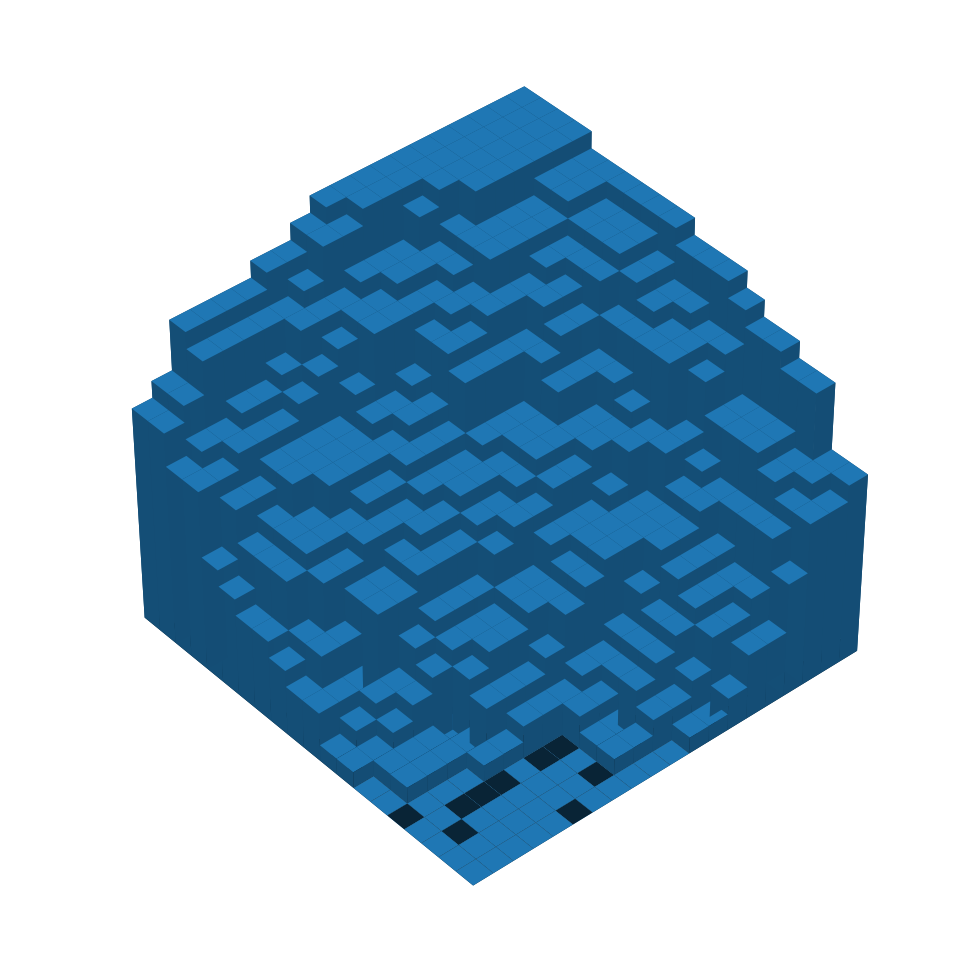

In [6]:
N = 20
upper_part = max_partition(N)
lower_part = min_partition(N)
moves = []
while not np.array_equal(upper_part, lower_part):
    pos = np.random.randint(N**2)
    delta = np.random.randint(2)*2 - 1
    moves.append((pos, delta))
    upper_part, _ = do_move(upper_part, pos, delta)
    lower_part, _ = do_move(lower_part, pos, delta)

for i in range(N):
    print(" ".join(["{:02d}".format(int(h)) for h in upper_part[i]]))
plot_plane_partition(lower_part.T)


In [7]:
def plot_plane_partition2(part1, part2, fig):
    N = len(part1)
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    xx, yy = np.meshgrid(np.arange(N), np.arange(N))
    x, y = xx.ravel(), yy.ravel()

    top = np.array(part1).flatten()
    bottom = np.zeros_like(top)
    width = depth = 1

    ls = LightSource(azdeg=90, altdeg=89)

    ax1.bar3d(x, y, bottom, width, depth, top, shade=True, lightsource=ls)
    ax1.set_xlim(0,N)
    ax1.set_ylim(0,N)
    ax1.set_zlim(0,N)
    ax1.view_init(40, 49)
    ax1.axis('off')

    top = np.array(part2).flatten()
    ax2.bar3d(x, y, bottom, width, depth, top, shade=True, lightsource=ls)
    ax2.set_xlim(0,N)
    ax2.set_ylim(0,N)
    ax2.set_zlim(0,N)
    ax2.view_init(40, 49)
    ax2.axis('off')

In [8]:
N = 20
upper_part = max_partition(N)
lower_part = min_partition(N)
moves = []
uppers = [upper_part]
lowers = [lower_part]
while not np.array_equal(upper_part, lower_part):
    pos = np.random.randint(N**2)
    delta = np.random.randint(2)*2 - 1
    moves.append((pos, delta))
    upper_part, changeA = do_move(upper_part, pos, delta)
    lower_part, changeB = do_move(lower_part, pos, delta)
    upper_part = np.array(upper_part)
    lower_part = np.array(lower_part)
    if changeA or changeB:
        uppers.append(upper_part)
        lowers.append(lower_part)
print(len(moves))
print(len(uppers))

1517693
575232


In [10]:
len(uppers) / 256

2247.0

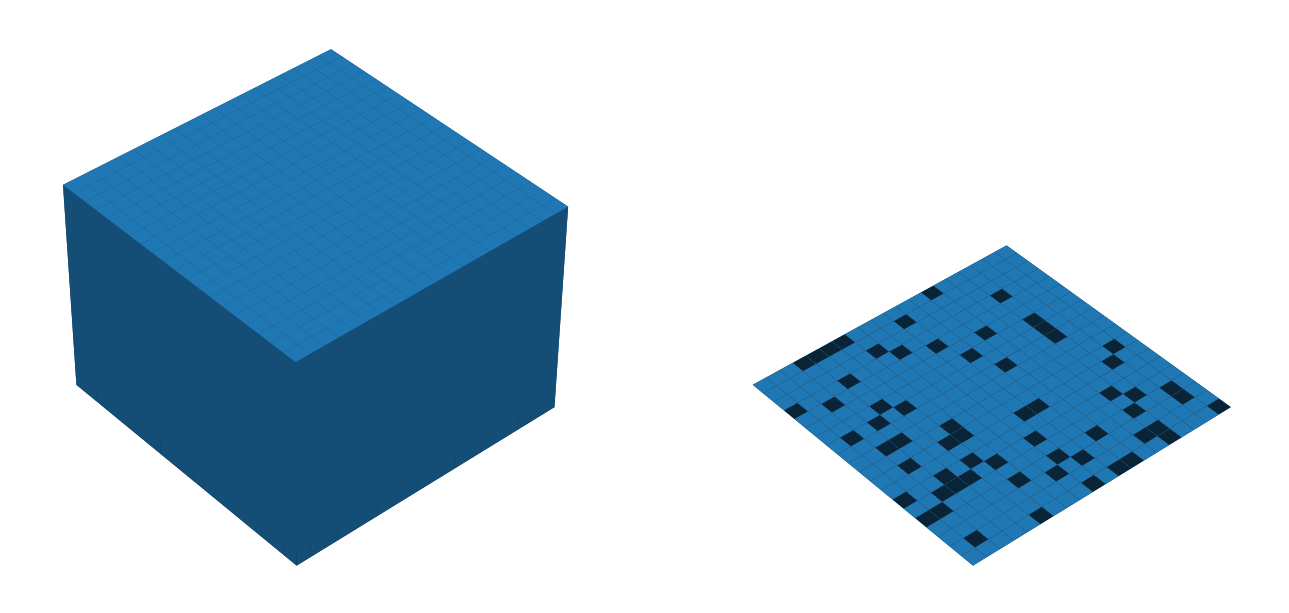

In [21]:
fig = plt.figure()

def init():
    plt.cla()
    plt.clf()
    plot_plane_partition2(uppers[0], lowers[0], fig)

def udate_parts(frame):
    plt.cla()
    plt.clf()
    plot_plane_partition2(uppers[(frame+1)*256], lowers[(frame+1)*256], fig)
    
video = animation.FuncAnimation(fig, udate_parts, init_func=init, frames=int(len(uppers)/256)-1, interval=10)

#Save the animation
video.save("box_anim2.mp4")